In [2]:
# Boilerplate code
from IPython.display import HTML, display
from helper import hide_toggle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorsignatures as ts
data = ts.TensorSignatureData(
    seed=573, 
    rank=5, 
    samples=100, 
    dimensions=[3, 5],
    mutations=1000)

%matplotlib inline
%config InlineBackend.figure_format='retina'

hide_toggle()

# The TensorSignatures API

The TensorSignatures API provides useful functions to analyse results from TensorSignature decompositions. Since running the tool usually involves creating several initialisations at different decomposition ranks, we provide three classes that abstract

* Experiments (`Experiment`), i.e. multiple initialisation at different decomposition ranks extracted using the same hyper parameters,
* Cluster (`Cluster`), i.e. multiple initialisations at a specific decomposition rank, 
* Initialisations (`Initialization`): a single decomposition.

## Importing data and performing model selection using the `Experiment` class

The `Experiment` class loads and clusters initialisations of each decomposition rank of a
hdf5 file written by `tensorsignatures write`

In [3]:
experiment = ts.Experiment("result2.h5")

/usr/local/lib/python3.7/site-packages/tensorsignatures-0.4.1-py3.7.egg/tensorsignatures/util.py:648: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.dset = h5.File(path)
Clustering initializations: 100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


The `data` field of an `Experiment` instance returns a set of keys, which allow us to access the `Cluster` of the experiment. Keys follow the format to prefix the decomposition rank with the name of the experiment, which we set earlier using the `-j` flag when we ran `tensorsignatures train`.

In [4]:
experiment.data

{'/tsTrain/10',
 '/tsTrain/2',
 '/tsTrain/3',
 '/tsTrain/4',
 '/tsTrain/5',
 '/tsTrain/6',
 '/tsTrain/7',
 '/tsTrain/8',
 '/tsTrain/9'}

The Experiment class computes a table of useful statistics,

In [5]:
experiment.summary_table.head()

,log_L1,log_L2,log_L,size,rank,init,params,observations,AIC,AIC_c,BIC,id
0,-1.018038e+06,-2895.712158,-1.020934e+06,50,9,0,6516,1319400,2054900.375,2.054965e+06,2.133696e+06,/tsTrain/9
1,-1.018134e+06,-2899.838623,-1.021034e+06,50,9,1,6516,1319400,2055099.375,2.055164e+06,2.133895e+06,/tsTrain/9
2,-1.018067e+06,-2892.347168,-1.020959e+06,50,9,2,6516,1319400,2054950.750,2.055015e+06,2.133747e+06,/tsTrain/9
3,-1.018035e+06,-2907.323730,-1.020942e+06,50,9,3,6516,1319400,2054916.500,2.054981e+06,2.133712e+06,/tsTrain/9
4,-1.018153e+06,-2898.298828,-1.021051e+06,50,9,4,6516,1319400,2055133.750,2.055198e+06,2.133930e+06,/tsTrain/9


which, for example, enable us to inspect log likelihood of each initialisation (Here we use the the `seaborn` library to create the plot. You can install the package, if necessary, by executing `pip install seaborn` in your terminal.)

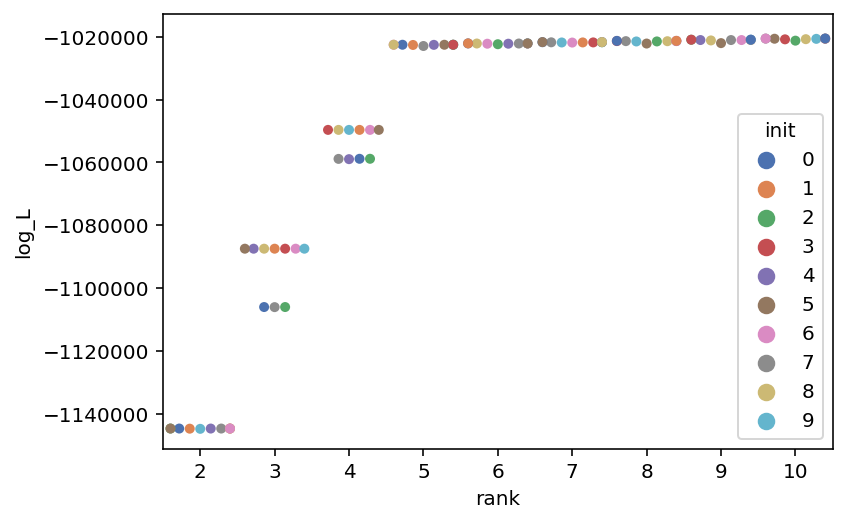

In [6]:
sns.swarmplot(x="rank", y="log_L", hue="init", data=experiment.summary_table, color="C0", palette="deep")

The `summary_table` also allows us to perform model selection using the Bayesian Information Criterion (BIC). This estimator tries to find a trade-off between the log-likelihood and the number of parameters in the model; chosen is the rank which minimises the BIC. To understand which model to choose in our experiment, we will quickly plot the rank against BIC,

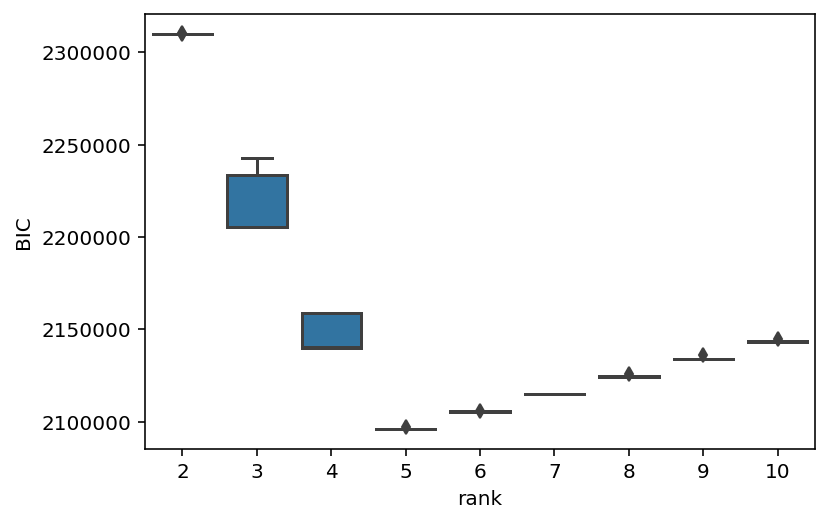

In [7]:
sns.boxplot(x="rank", y="BIC", data=experiment.summary_table, color="C0")

indicating that rank 5 is most appropriate for our dataset.

## The `Cluster` class wraps multiple TensorSignature initialisations

We can extract the cluster of a specific decomposition rank by passing these keys to the getter function of an Experiment object. For example, to extract the rank 5 solution, we execute

In [9]:
cluster = experiment["/tsTrain/5"]

A `Cluster` instance is essentially a wrapper for multiple `Initializations`. It embodies attributes to access the parameters of a tensor signature inference, for example, we may access the extracted signature tensor(s) through the `S` field of `Cluster`.

In [10]:
cluster.S.shape

(3, 3, 3, 5, 96, 5, 10)

Note the similarity between the shape of the extracted signature tensor and the shape of the input `snv` count tensor (`(3, 3, 3, 5, 96, 100)`). First few indices match the size of corresponding genomic dimensions, i.e. transcription and replication directionality (each `3`), genomic dimension 1 and 2 (`3` and `5`) and single base substitution types (`96`). The following two indices, however, indicate the decomposition rank (`5`) rather than the number of samples, and the number initialisations in the cluster.

Other model parameters may be accessed through the following fields:

* Other mutation type signatures: `result.T`
* Exposures: `result.E`
* Transcription and replicational strand biases: `result.b`
* Signature activities in transcribed/untranscribed regions and early/late replicating regions: `result.a`
* Arbitrarygenomicproperty(likeepigeneticsignatureactivities): `result.k0`, `result.k1`, ..., `result.kx`
* Mixing proportions: `result.m`


The last dimension of an extracted Cluster parameter always indicates the number of available initialisations. To extract the solution of a particular initialisation, we can can simply index it using standard numpy indexing. Here we make use of the so called ellipsis operator (`...`) which enables to index the last dimension of an multidimensional array

In [11]:
solution = cluster.b[..., 3]
solution.shape

(2, 5)

`Cluster` objects provide an init field containing the index of the initialisation with the highest log-likelihood. To extract this particular `Initialization` from a cluster, we simply pass it to the `Cluster` getter function

In [12]:
init = cluster[cluster.init]

A `Initialization` object stores tensor signatures, factors and exposures

Similar to TensorSignature `Cluster` objects, `Initializations` contain the fitted model including all parameters. For example, we can access the extracted signature tensor by accessing the `S` field from `init`.

In [13]:
init.S.shape

(3, 3, 3, 5, 96, 5, 1)

Note that the last dimension of `S` has a size of one, indicating an initialisation rather than a clustered signature tensor. Two other useful methods of `Initialization` objects are `to_dic` and `dump`, which let us serialise and save the result of a TensorSignature initialisation to the hard disk.

In [ ]:
# returns a dictionary with all parameters
init.to_dic()
# saves the initialisation to disk (load a saved solution with\ ts.load_dump)
init.dump(‘initialisation.pkl’)

The TensorSignatures API features some basic plotting function which allow us to visualise the extracted parameters of an `Initialisation`.

* `plot_signatures`: plots single base substitution spectra in context of transcription and replication
* `heatmap`: plots tensor factors (transcription and replication biases (`b`), signature activities (`a`), and genomic activities (`k0`, `k1`, ... , `kx`))

The `ts.plot_signatures` function expects an 5 dimensional array `(3, 3, -1, 96, rank)`. Due to the fact that we can have an arbitrary number of genomic states, we first have to reshape the signature tensor before we can pass it to the plotting function.

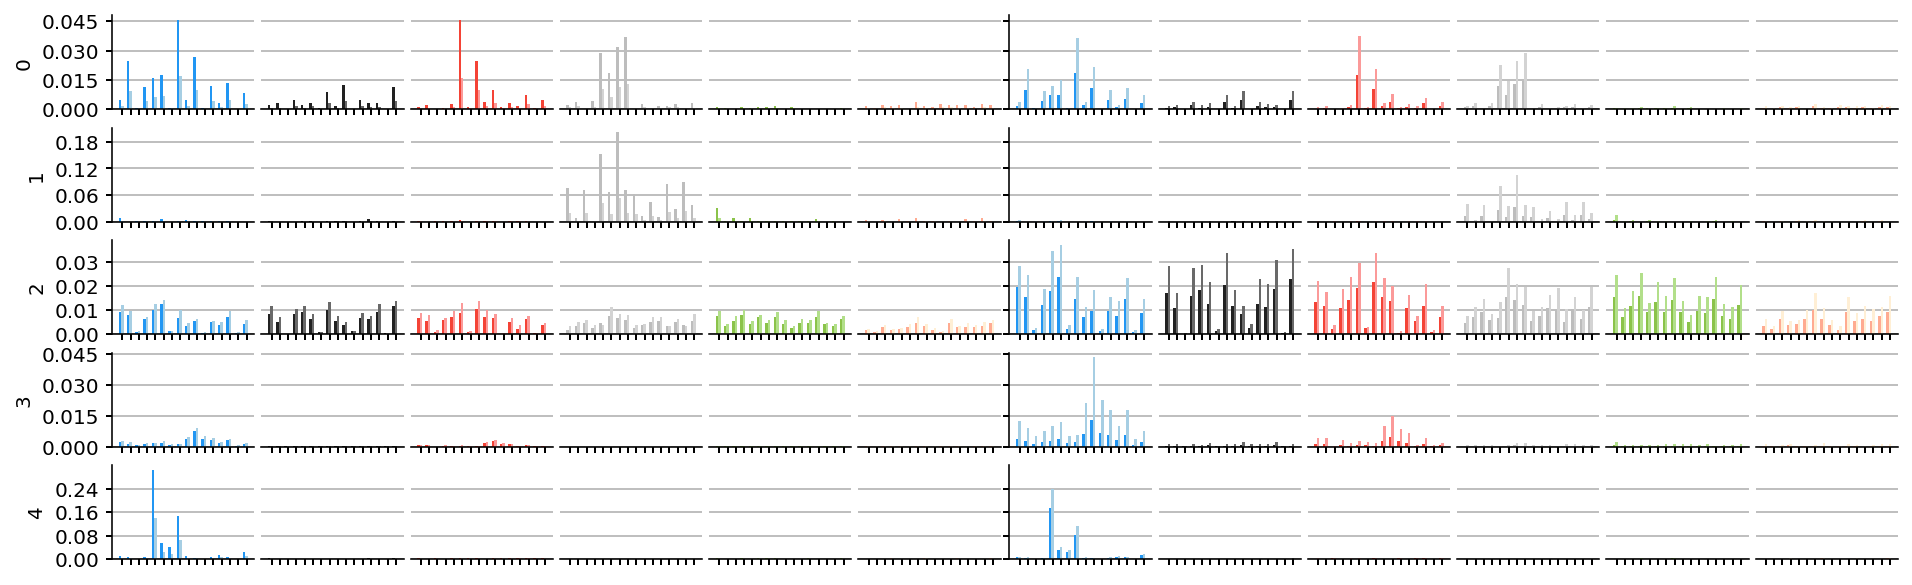

In [14]:
plt.figure(figsize=(16, 5))
ts.plot_signatures(init.S.reshape(3, 3, -1, 96, init.rank))

We can plot extracted tensor factors `result.b`, `result.a`, `result.k0` and `result.k1` using the `ts.heatmap` function. Note, that similarly to the the signature tensor, the `Initialization` object appends an additional dimension to indicate its index. For this reason, we need to reshape the arrays containing tensor factors or index them appropriately.

In [16]:
init.b.shape # transcription and replication strand biases

(2, 5, 1)

(<matplotlib.image.AxesImage at 0x7f396b792cf8>,
 <matplotlib.colorbar.Colorbar at 0x7f396a5761d0>)

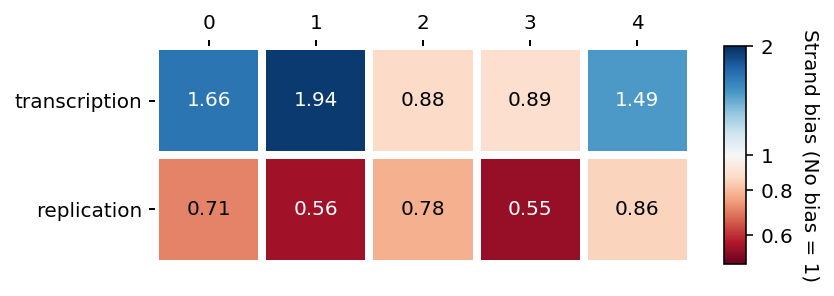

In [19]:
# ... (the elipsis operator) allows to index the last dimension of an array
plt.figure(figsize=(6,2))
ts.heatmap(init.b[..., 0],
           vmin=.5, vmax=2,
           row_labels=["transcription", "replication"], col_labels=["{}".format(i) for i in range(5)],
           cbarlabel="Strand bias (No bias = 1)" # color bar label
)

## Running TensorSignatures through the API

In some scenarios it might be desirable to run TensorSignatures via the API rather than the CLI (for example when integrating TensorSignatures into custom pipelines). To illustrate this, we first simulate data and extract the SNV count tensor and the matrix containing other mutation types. Here it is important to notice that the sample dimensions have to match, e.g. `snv[..., 4]` has to match `other[..., 4]`.

In [21]:
data = ts.TensorSignatureData(
    seed=573, # set a seed for reproducibility
    rank=5, # number of signatures
    samples=100, # number of samples
    dimensions=[3, 5], # number of arbitrary genomic dimensions mutations=1000)
    mutations=1000)

snv = data.snv() # the SNV count tensor (3, 3, 3, 5, 96, 100)
other = data.other() # other mutation type matrix (234, 100)

The next step is to pass the desired decomposition rank, as well as the input data, i.e. the snv count tensor and the other mutation matrix, to the `TensorSignature` class (When working with real genomic data it is also necessary to pass a normalisation tensor (via the argument `N`) which accounts for differences in the nucleotide composition of different genomic regions to the `TensorSignature` constructor.). The TensorSignature constructor also receives other model hyperparameters such as learning rate of the model or the number of epochs to train the model. By default, TensorSignatures uses the outlier robust negative binomial distribution with a dispersion $\tau = 50$ to model the mutation count, and trains the model for 10,000 epochs.

In [ ]:
# perform a rank 5 decomposition
model = ts.TensorSignature(snv, other, rank=5, verbose=True, epochs=20000)

To fit the signatures to our data, we simply invoke the `fit` method of the model instance, which will return a `Initialization` object after finishing to train the model.

In [ ]:
result = model.fit()